In [1]:
import nltk
import os
import pandas as pd
import numpy as np
import csv
import random
import re

In [2]:
# "\" is used to escape the meta-meaning of "\".
os.getcwd() 

'C:\\Users\\WANGJ\\Downloads\\Homework\\StandardTools'

In [3]:
# show training data csv files
os.listdir("C:\\Users\\WANGJ\\Downloads\\Homework\\StandardTools\\Training_data")

['2001-01-20-George-W-Bush.sent.csv',
 '2009-01-20-Barack-Obama_sent.csv',
 '2017-01-20-Donald-J-Trump_sent.csv']

In [4]:
from nltk import word_tokenize
from nltk.tag.stanford import StanfordPOSTagger

java_path = "C:\\Program Files\\Java\\jdk1.8.0_191\\bin\\java.exe" 
os.environ["JAVAHOME"] = java_path

# enter the paths of Stanford POS Tagger .jar file as well as the model to be used
jar = "C:\stanford\stanford-postagger-full-2018-10-16\stanford-postagger-full-2018-10-16\stanford-postagger-3.9.2.jar"
model = "C:\stanford\stanford-postagger-full-2018-10-16\stanford-postagger-full-2018-10-16\models\english-left3words-distsim.tagger"
# Instantiate an English pos-tagger using the jar and model defined above 
pos_tagger_en = StanfordPOSTagger(model, jar, encoding = "utf-8")

In [5]:
# Get indexes of all coordinators
def get_index_of_coor(sent):
    split_sent = sent.split()
    indexes_of_coor = [-1]  # this ancillary element is used to compute the index of the first coordinator
    for w in split_sent:
        if w.startswith(",") or w.endswith("_CC") or w.lower() == "while_in":
            # Use the formula to get the right index 
            # indexes_of_coor[-1] means the last element(index) of the index list
            indexes_of_coor.append(split_sent.index(w) + indexes_of_coor[-1] +1 ) 
           
            # chop the previous part of the sentence off (by +1) in order to find the next coordinator
            split_sent = split_sent[(split_sent.index(w) +1) :]  
            
    # Exclude the conjunction at the beginning of the sentence       
    if 0 in indexes_of_coor:   
        indexes_of_coor = indexes_of_coor[2:]
    else:
        indexes_of_coor = indexes_of_coor[1:] # First ancillary index should be excluded
    return indexes_of_coor  



In [6]:
# used for comparing 2 phrases as string
from difflib import SequenceMatcher

def compare(str1, str2):
    return SequenceMatcher(None, str1, str2).ratio() 
# returns the similarity score (float in [0,1]) between input strings, the higher the score is, more similar 2 Strings are. 

In [7]:
# Get the PoS-tag sequence(return a string) of the given subsentence(type: list)
# With normalization
def get_pos_seq (word_tag_sequence):
    pos_sequence = "".join([w[w.index("_"):w.index("_")+3] for w in word_tag_sequence if len(w)>2])
    return pos_sequence

In [8]:
# Get the PoS-tag sequence(return a string) of the given subsentence(type: list)
# Without normalization
def get_pos_seq_raw (word_tag_sequence):
    pos_sequence = "".join([w[w.index("_"):] for w in word_tag_sequence if len(w)>2])
    return pos_sequence

In [9]:
def similar(prev, after):
    similar_pair = 0
    if len(prev) > 2 and len(after) > 2:
        
        if len(prev) == len(after):
            if compare(get_pos_seq(prev), get_pos_seq(after)) > 0.79 or compare(
            get_pos_seq(prev[1:]), get_pos_seq(after)) > 0.79 or compare(
            get_pos_seq(prev[2:]), get_pos_seq(after)) > 0.79 or compare(
            get_pos_seq(prev), get_pos_seq(after[: -1])) > 0.79 or compare(
            get_pos_seq(prev), get_pos_seq(after[: -2])) > 0.79:
                #print("1")
                similar_pair += 1
        elif len(prev) - len(after) == 1:   # previous subsentence is longer, so latter subsentence as length-base
            if compare(get_pos_seq(prev[-len(after) :]), get_pos_seq(after)) > 0.79 or compare(
            get_pos_seq(prev[-len(after)-1:]), get_pos_seq(after)) > 0.79:
                #print("2")
                similar_pair += 1
        elif len(prev) - len(after) >= 2:
            if compare(get_pos_seq(prev[-len(after) :]), get_pos_seq(after)) > 0.79 or compare(
            get_pos_seq(prev[-len(after)-1:]), get_pos_seq(after)) > 0.79 or compare(
            get_pos_seq(prev[-len(after)-2:]), get_pos_seq(after)) > 0.79:
                #print("3")
                similar_pair += 1
        elif len(prev) - len(after) == -1:
            if compare(get_pos_seq(prev), get_pos_seq(after[:len(prev)])) > 0.79 or compare(
            get_pos_seq(prev), get_pos_seq(after[:len(prev)+1])) > 0.79:
                #print("4")
                similar_pair += 1
        elif len(prev) - len(after) <= -2:
            if compare(get_pos_seq(prev), get_pos_seq(after[:len(prev)])) > 0.79 or compare(
            get_pos_seq(prev), get_pos_seq(after[:len(prev)+1])) > 0.79 or compare(
            get_pos_seq(prev), get_pos_seq(after[:len(prev)+2])) > 0.79:
                #print("5")
                similar_pair += 1
   
   # If one of the subsentence is less than 3 words, no normalization of PoS-tags will be performed                 
    elif len(prev) == 2 or len(after) == 2: 
        if len(prev) >= len(after):
            if compare(get_pos_seq_raw(prev[-len(after):]), get_pos_seq_raw(after)) == 1:
                similar_pair += 1
        if len(prev) < len(after):
            if compare(get_pos_seq_raw(prev), get_pos_seq_raw(after[:len(prev)])) == 1:
                similar_pair += 1
                
    return similar_pair
                
        

In [10]:
# for reversed parallelism
def reversed_simi(prev, after):
    similar_phrase_pair = 0
    if len(prev) > 1 and len(after) > 1:
        pos = after[0][after[0].index("_"):]
        for w in prev[1:]:   # avoid "index_out_of_range" problem
            if w.endswith(pos):
                reverse_start = w
                index_reverse_start = prev.index(reverse_start)
                w_before = prev[index_reverse_start - 1]
                if w_before[w_before.index("_"):] == after[1][after[1].index("_"):]:
                    similar_phrase_pair += 1
    return similar_phrase_pair

In [11]:
# Only extract word-recurrence in particular positions
def recurrence_w (prev, after):
    recur = 0
    if len(prev) >= len(after):
        length = len(after)
        for index in range(length):
            if prev[-length : ][index].lower() == after[index].lower():
                recur += 1
    if len(prev) < len(after):
        length = len(prev)
        for index in range(length):
            if prev[index].lower() == after [: length][index].lower():
                recur += 1
    return recur

In [12]:
def num_of_CC(sent):
    sp_sent = sent.split()
    counter = 0
    for w_t in sp_sent:
        if w_t.endswith("_CC"):
            counter += 1
    return counter

In [13]:
def trigram_repetition(sent):
    num_tri = 0
    if len(sent.split()) > 2:
        
        trigrams = list(nltk.trigrams([w[w.index("_"):] for w in sent.split() if len(w)>2]))
        if len(trigrams) == 5:
            if trigrams[0] == trigrams[4]:
                num_tri += 1
        if len(trigrams) == 6:
            if trigrams[0] == trigrams[4] or trigrams[0] == trigrams[5] or trigrams[1] == trigrams[5]:
                num_tri += 1
        if len(trigrams) > 6:
            for i in range(len(trigrams)-4):
                if trigrams[i] == trigrams[i+4]:
                    num_tri += 1
            for i in range(len(trigrams)-5):
                if trigrams[i] == trigrams[i+5]:
                    num_tri += 1
    return num_tri

In [14]:
def get_features(sent):
    features = {}
    recurrence = 0
    similar_phrase_pair = 0
    reversed_simi_pair = 0
    
    norm_sent = re.sub("...?_CC (also|not)_RB", ",_,", sent)  # nomalization: change "but_CC also_RB/not_RB" this kind of pattern into ",_,"
    norm_sent = re.sub("are_VBP not_RB", ",_,", norm_sent)
    norm_sent = re.sub(",_,.?,_,", ",_,", norm_sent)         # last step could result with ",_, ,_,"
    norm_sent = re.sub(",_, ...?_CC", ",_,", norm_sent)      # nomalization: change ",_, and_CC/or_CC/but_CC" this kind of pattern into ",_,"
    coor_indexes = get_index_of_coor(norm_sent)
    process_sent = norm_sent.split()[: -1]                   # chop the "sentence closer off"
           
    if len(coor_indexes) == 1:   # only 2 sub-sentences
        prev, after = process_sent[: coor_indexes[0]], process_sent[coor_indexes[0] + 1 :]
        similar_phrase_pair += similar(prev, after)
        recurrence += recurrence_w(prev, after)
        if "nor" in sent:
            similar_phrase_pair += reversed_simi(prev, after)
        
    elif len(coor_indexes) > 1:
        prev = process_sent[: coor_indexes[0]]             # First sentence
        for ii in range(len(coor_indexes) - 1):
            after = process_sent[coor_indexes[ii] + 1 : coor_indexes[ii + 1]]
            similar_phrase_pair += similar(prev, after)
            recurrence += recurrence_w(prev, after)
            if "nor" in sent:
                similar_phrase_pair += reversed_simi(prev, after)
            prev = after
            
        after = process_sent[coor_indexes[-1] + 1 :]        # Last sentence
        similar_phrase_pair += similar(prev, after)
        recurrence += recurrence_w(prev, after)
        if "nor" in sent:
            similar_phrase_pair += reversed_simi(prev, after)
            
# If by now no similar structures are found, try to split the sentence by <comma>, because conjunction words
# like "and" might be part of the parallel elements
    s = sent[:-4]     # chop off the sentence-closer
    ssplit = s.split(",_,")
    if len(ssplit) > 1:
        for i in range(len(ssplit)-1):
            similar_phrase_pair += similar(ssplit[i].split(), ssplit[i+1].split())

                
# If by now no similar structures are found, try to identify [A, B cc C], [A cc B cc C] or [A, B, C] types (structure consist of only one word) 
    
    if len(sent.split()) > 4:      # for these types, sentence should contain at least 5 words.
        tag_sequence = [w[w.index("_") :] for w in sent.split() if len(w)>2]  # use full PoS-Tag
        for index in range(len(tag_sequence) - 4):
            t1 = tag_sequence[index]
            t2 = tag_sequence[index + 2]
            t3 = tag_sequence[index + 4]
            if t1 == t2 == t3 and ((tag_sequence[index+1] == "_CC" and tag_sequence[index+3] == "_CC") or (
            tag_sequence[index+1] == "_," and (tag_sequence[index+3] == "_," or tag_sequence[index+3] == "_CC"))):
                #print(tag_sequence)
                similar_phrase_pair += 1
                
# If still no similar structures are found, try to identify [A, B cc C] types (structure consist of only one word)                             
   
                    
    features["simi"] = similar_phrase_pair > 0
    features["recur"] = recurrence
    features["num_CC"] = num_of_CC(sent)
    features["num_tri"] = trigram_repetition(sent) > 0
    return features


In [15]:
# define this function for evaluation
def compute_PRF(gold, predicted, class_label):
    TP = sum(int(g == class_label and p == class_label) for (g, p) in zip (gold, predicted))
    FP = sum(int(p == class_label and g != class_label) for (g, p) in zip (gold, predicted)) 
    FN = sum(int(p != class_label and g == class_label) for (g, p) in zip (gold, predicted))
    if TP + FP > 0:
        precision = TP/(TP + FP)
    else:
        precision = 0
    if TP + FN > 0:
        recall = TP/(TP + FN)
    else:
        recall = 0
    if precision > 0 and recall > 0:
        f_measure = 2 * precision * recall / (precision + recall)
    else:
        f_measure = 0
    #print('Precision=%.2f Recall=%.2f F_Measure=%.2f'  %  (precision, recall, f_measure))
    return (precision, recall, f_measure)

In [16]:
data_set_raw1 = []
for file in os.listdir("C:\\Users\\WANGJ\\Downloads\\Homework\\StandardTools\\Training_data"):
    if file.endswith("csv"):
        with open(".\\Training_data\\" + file, encoding = "utf-8") as f:
            reader = csv.reader(f, delimiter = ",")
            rows = [row for row in reader]
            data_set_raw1.extend(rows[1:])   # the first row is the header ["sentence", "Tag"], so not needed
print(len(data_set_raw1))
data_set = [(sent, tag) for [sent, tag] in data_set_raw1]
print(data_set[:5])

380
[('Inaugural_JJ Address_NNP January_NNP 20_CD ,_, 2001_CD Public_NNP Papers_NNP of_IN the_DT Presidents_NNS George_NNP W._NNP Bush_NNP <_JJR br_NN >_JJR 2001_CD :_:', 'f'), ('Book_VB I_PRP George_NNP W._NNP Bush_NNP 2001_CD :_:', 'f'), (' Book_VB I_PRP video_JJ Location_NNP :_:\n', 'f'), (' District_NNP of_IN Columbia_NNP Washington_NNP The_NNP American_NNP Presidency_NNP Project_NNP\n', 'f'), ('Thank_VB you_PRP ,_, all_DT ._.', 'f')]


In [17]:
data_set_raw2 = []
for file in os.listdir("C:\\Users\\WANGJ\\Downloads\\Homework\\StandardTools\\Training_data"):
    if file.endswith("csv"):
        with open(".\\Training_data\\" + file, encoding = "utf-8") as f:
            reader = csv.reader(f, delimiter = ",")
            rows = [row for row in reader]
            data_set_raw2.extend(rows[1:])
print(data_set_raw2[:3])

[['Inaugural_JJ Address_NNP January_NNP 20_CD ,_, 2001_CD Public_NNP Papers_NNP of_IN the_DT Presidents_NNS George_NNP W._NNP Bush_NNP <_JJR br_NN >_JJR 2001_CD :_:', 'f'], ['Book_VB I_PRP George_NNP W._NNP Bush_NNP 2001_CD :_:', 'f'], [' Book_VB I_PRP video_JJ Location_NNP :_:\n', 'f']]


In [18]:
transformed_data = []
for [sent, tag] in data_set_raw2:
    features_tag = []
    simi = get_features(sent)["simi"]
    recur = get_features(sent)['recur']
    num_CC = get_features(sent)["num_CC"]
    num_tri = get_features(sent)["num_tri"]
    features_tag.extend([sent,simi,recur,num_CC, num_tri,tag])
    transformed_data.append(features_tag)  # use append to maintain list form

df_data = pd.DataFrame(transformed_data, columns = ['sent','simi','recur',"num_CC",'num_tri','tag'])

feature_cols = ['simi','recur','num_CC','num_tri']
# select all 10 features (X)
X = df_data[feature_cols]
# select numerical tag as responses/targets (y)
y = df_data.tag

In [19]:
# Try different algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC 
# Instantiate classifiers
KNC = KNeighborsClassifier()
LR = LogisticRegression()
SVC = LinearSVC()

In [20]:
def process_file_sent(path, withTag):   # path of the file as string
    with open (path, encoding = "utf-8") as f:   
        raw = f.read()
        tokenized_text = word_tokenize(raw)              # tokenizing
        tagged_text = pos_tagger_en.tag(tokenized_text)  # pos-tagging
        
    with open (path + "processed", "w", encoding = "utf-8") as processed_f:
        write_text = ""
        for (a, b) in tagged_text:
            write_text += a + "_" + b +" "   # combine word and tag together in the format: "My_PRP$ "
            
            # add newline character after the character which marks the end of a sentence 
        result = write_text.replace("_. ", "_.\n").replace(";_:", ";_:\n").replace(
            ":_:", ":_:\n")   # "_." include "!", "?" these sentence closers
                
        processed_f.write(result)       # write all the results into corresponding .txt file    
        
# Get corresponding .xlsx files which contain every sentence of the speech in the first column.            
    if withTag == True:
        with open (path + "processed", encoding = "utf-8") as f:
            reader = csv.reader(f, delimiter = ";")
            rows = [row for row in reader]
            
            df_sent = pd.DataFrame({"sentence" : rows})
            df_sent.to_csv (path + "processed_sent(tag).csv", encoding = "utf-8", index = False)
        
    if withTag == False:
        with open (path + "processed", encoding = "utf-8") as f:
            reader = csv.reader(f, delimiter = ";")
            rows = [row for row in reader]
            sents = []
            for row in rows:
                sents.append(" ".join([w[: w.index("_")] for w in row.split() if len(w)>2])) 
            df_sent = pd.DataFrame({"sentence" : sents})
            df_sent.to_csv (path + "processed_sent.csv", encoding = "utf-8", index = False)
            

In [21]:
def transform (path): # path of the file as string
    with open (path + "processed_sent(tag).csv", encoding = "utf-8") as f:
        reader = csv.reader(f, delimiter = ",")
        rows = [row for row in reader]
        transformed_data = []
        for [sent] in rows[1:]:   # "sentence" in the first row?
            features = []
            simi = get_features(sent)['simi']
            recur = get_features(sent)['recur']
            num_CC = get_features(sent)['num_CC']
            num_tri = get_features(sent)['num_tri']
            sentences = " ".join([w[: w.index("_")] for w in sent.split() if len(w) > 2])
            features.extend([sentences[2:], simi, recur, num_CC, num_tri])
            transformed_data.append(features)  # use append to maintain list form
        
        df_data = pd.DataFrame(transformed_data, columns = ['sentences','simi','recur','num_CC','num_tri'])
        
    return df_data

In [22]:
# use all Inaugural Speech data as training data to develop classifiers to tag other texts
featuresets = [(get_features(sent), tag) for (sent, tag) in data_set]
# Train classifiers in different ways
NB = nltk.NaiveBayesClassifier.train(featuresets)
KNC = KNC.fit(X, y)
LR = LR.fit(X, y)
SVC = SVC.fit(X, y)

In [23]:
def tag_file_sklearn (path, clf): # path of the file as string
    df_data = transform(path)
    X_features_test = df_data[feature_cols]
    y_tag_pred = clf.predict(X_features_test)
    df_data["tag"] = y_tag_pred
    df_data["tag"] = df_data.tag.map({ "f" : 'Non-parallelism' , "t" : 'Parallelism'})
    df_data.to_csv(path + "tagged.csv", encoding = "utf-8", columns = ['sentences', 'tag'], index = False)
    #df_data.to_csv(path + "tagged.csv", encoding = "utf-8", columns = ['sent', 'tag'], index = True)

In [24]:
def tag_file_nltk (path, clf): # path of the file as string
    with open (path, encoding = "utf-8") as f:   
        raw = f.read()
        tokenized_text = word_tokenize(raw)              # tokenizing
        tagged_text = pos_tagger_en.tag(tokenized_text)  # pos-tagging
        
    with open (path + "processed", "w", encoding = "utf-8") as processed_f:
        write_text = ""
        for (a, b) in tagged_text:
            write_text += a + "_" + b +" "   # combine word and tag together in the format: "My_PRP$ "
            
            # add newline character after the character which marks the end of a sentence 
        result = write_text.replace("_. ", "_.\n").replace(";_:", ";_:\n").replace(
            ":_:", ":_:\n")   # "_." include "!", "?" and "." these sentence closers
                
        processed_f.write(result)       # write all the results into corresponding .txt file         
            
    with open (path + "processed", encoding = "utf-8") as f:
        sentences = []
        reader = csv.reader(f, delimiter = ";")
        rows = [row for row in reader]
        for row in rows:
            sentences.append(str(row)[2:-1])
        df_data = pd.DataFrame({"sentence" : rows})    
        tag_pred = [clf.classify(get_features(sent)) for sent in sentences] 
        df_data["tag"] = tag_pred
        df_data["tag"] = df_data.tag.map({ "f" : 'Non-parallelism' , 't' : 'Parallelism'})
        df_data["sentences"] = [" ".join([w[:w.index("_")] for w in sent.split() if len(w) > 2]) for sent in sentences]
        df_data.to_csv(path + "tagged.csv", encoding = "utf-8", columns = ['sentences', 'tag'], index = False)

In [25]:
def tag_file(path, clf):
    process_file_sent(path, True)
    transform(path)
    if clf in [KNC,LR,SVC]:
        tag_file_sklearn(path, clf)
    elif clf == NB:
        tag_file_nltk(path, clf)

In [26]:
# Print all sentences with parallelism and can write them into a new file
# Format choice: txt, xlsx)

def getParallelism (path, Format):
    with open (path,  encoding = "utf-8") as f:
        reader = csv.reader(f, delimiter = ",")
        rows = [row for row in reader]
        parallel = []
        for [sent, tag] in rows:
            if tag == "Parallelism":
                parallel.append(sent)
    
        n = 1
        for s in parallel:
            print(n, s)
            n += 1
    if Format  == "txt":
        with open(path + "Parallelism.txt", "w", encoding = "utf-8") as f:
            result = ""
            n = 1
            for s in parallel:
                result += str(n) +" " + s +"\n\n"
                n += 1
            f.write(result)
    elif Format == "xlsx":
        with open(path + "Parallelism.txt", "w", encoding = "utf-8") as f:
            df_sent = pd.DataFrame({"Sentences with parallelism" : parallel})
            df_sent.to_excel(path + "Parallelism.xlsx", encoding = "utf-8", index = False)
        

In [27]:
# Sometimes need to run more than 1 time to get plotted graph instead of a generator.

from nltk.draw import dispersion_plot

def parallelism_Dispersion (path):
    with open (path, encoding = "utf-8") as f:
        reader = csv.reader(f, delimiter = ",")
        rows = [row for row in reader]
        all_tags = []
        for [sent, tag] in rows:
            all_tags.append(tag)
        all_tags_as_text = nltk.Text(all_tags)
        print(dispersion_plot(all_tags_as_text, ["Parallelism","Non-parallelism"]))


In [28]:
# For parameter "percentage" enter a float number 
# which specifies the percentage of the text (based on number of sentences) considered as text-initial part.
# This percentage also applies for text-final part.

# The function prints out 3 values respectively for the ratio between sentences with and without parallelism
# in text-initial, text-medial and text-final positions.

def para_NonPara_ratio(path, percentage):
    with open(path, encoding = "utf-8") as f:
        reader = csv.reader(f, delimiter = ",")
        rows = [row for row in reader]
        all_tags = []
        for [sent, tag] in rows:
            all_tags.append(tag)
        size = len(all_tags)
        text_initial = all_tags[: int(size * percentage)]
        text_medial = all_tags[int(size * percentage): -int(size * percentage)]
        text_final = all_tags[-int(size * percentage) :]
        r1 = text_initial.count("Parallelism")/text_initial.count("Non-parallelism")
        r2 = text_medial.count("Parallelism")/text_medial.count("Non-parallelism")
        r3 = text_final.count("Parallelism")/text_final.count("Non-parallelism")
        r_All = all_tags.count("Parallelism")/all_tags.count("Non-parallelism")
        print(len(text_initial), " sentences in text_initial part.", "(",percentage *100,"%)")
        print(len(text_medial), " sentences in text_medial part. ", "(",100 - 2*percentage*100,"%)")
        print(len(text_final), " sentences in text_final part.  ", "(",percentage*100,"%)")
        print("In text-initial part, Parallelism/Non-parallelism ratio is: %.3f" % r1)
        print("In text-medial part, Parallelism/Non-parallelism ratio is:  %.3f" % r2)
        print("In text-final part, Parallelism/Non-parallelism ratio is:   %.3f" % r3, "\n")
        print("Overall Parallelism/Non-parallelism ratio of the text:      %.3f" % r_All)
    return (r1, r2, r3, r_All)

In [29]:
# Label name should be "t"(parallelism) or "f"(non-parallelism)
def evaluate(path_manual, path_pred, lablel, show_FP, show_FN):
    manual_tags = []
    pred_tags = []
    with open(path_manual, encoding = "utf-8" ) as f:
        reader = csv.reader(f, delimiter = ",")
        rows = [row for row in reader]
        for [sent, tag] in rows[1:]:
            manual_tags.append(tag)
    with open(path_pred, encoding = "utf-8") as f:
        reader = csv.reader(f, delimiter = ",")
        rows = [row for row in reader]
        for [sent, tag] in rows:
            if tag == "Parallelism":
                pred_tags.append("t")
            if tag == "Non-parallelism":
                pred_tags.append("f")
                
        if show_FP == True:
            print("False Positives:\n")
            for i in range(len(manual_tags)):
                if manual_tags[i] == "f" and pred_tags[i] == "t":
                    print(rows[i+1][0], "\n")     # Take the header row into account
        if show_FN == True:
            print("\nFalse Negatives:\n")
            for i in range(len(manual_tags)):
                if manual_tags[i] == "t" and pred_tags[i] == "f":
                    print(rows[i+1][0],"\n")
                
    print("\nAltogether ", len(manual_tags), "manually assigned tags.")
    print("Altogether ", len(pred_tags), "predicted tags.\n")
    print('Precision=%.2f Recall=%.2f F_Measure=%.2f'  %  compute_PRF(manual_tags, pred_tags, "t"))
    

In [30]:
tag_file(".\\Test_data\\test2.txt", LR)

In [31]:
getParallelism(".\\Test_data\\test2.txttagged.csv","xlsx")

1 That room represented the sacrifices of generations gone by who , by poverty or by policy , could n't afford a curio of collectibles let alone a middle class house to put them in .
2 Septima Clark was an activist and an educator , a woman after whom I 'd eventually model my own career .
3 But by most measures , we have more knowledge and more resources now than at any other point in history , and still injustice abounds and challenges persist .
4 Some of them were immigrants , some of them were disabled , but all of them were the very last people this world invites to be confident .
5 That 's why it was so important that my classroom be a place where my students could build the muscle of confidence , where they could learn to face each day with the confidence you need to redesign the world in the image of your own dreams .
6 He would squirm in his chair during independent work , and he would never stay still for more than three or four minutes .
7 If he could give me focused work , t

In [32]:
evaluate(".\\Test_data\\manual_tag.csv",".\\Test_data\\predicted_lr.csv","t",False, False)


Altogether  256 manually assigned tags.
Altogether  256 predicted tags.

Precision=0.78 Recall=0.83 F_Measure=0.80


In [33]:
evaluate(".\\Test_data\\manual_tag.csv",".\\Test_data\\predicted_nb.csv","t",False, False)


Altogether  256 manually assigned tags.
Altogether  256 predicted tags.

Precision=0.72 Recall=0.83 F_Measure=0.77


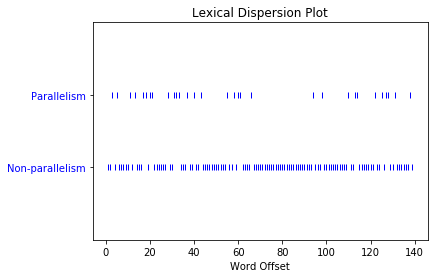

None


In [36]:
parallelism_Dispersion(".\\Test_data\\test1.txttagged.csv")

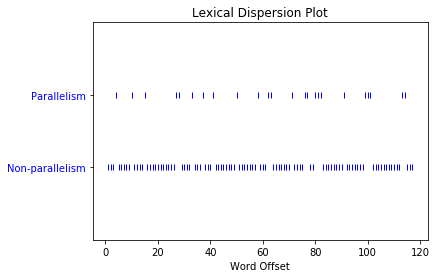

None


In [37]:
parallelism_Dispersion(".\\Test_data\\test2.txttagged.csv")

In [35]:
para_NonPara_ratio(".\\Test_data\\test1.txttagged.csv", 0.15)

21  sentences in text_initial part. ( 15.0 %)
98  sentences in text_medial part.  ( 70.0 %)
21  sentences in text_final part.   ( 15.0 %)
In text-initial part, Parallelism/Non-parallelism ratio is: 0.538
In text-medial part, Parallelism/Non-parallelism ratio is:  0.225
In text-final part, Parallelism/Non-parallelism ratio is:   0.400 

Overall Parallelism/Non-parallelism ratio of the text:      0.287


(0.5384615384615384, 0.225, 0.4, 0.28703703703703703)